In [1]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import cross_val_score, LeaveOneOut
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

INPUT_PATH = Path("/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize")
OUTPUT_PATH = Path("/mnt/storage/kaggle_output/commonlitreadabilityprize")

In [2]:
model_folders = [
        # complex-heron-of-science - roberta-base
        "20210609-171109",
        "20210609-174639",
        "20210609-182121",
        "20210609-192843",
        "20210609-200242",
        # impetuous-marvellous-cockle - roberta-large
        "20210608-233655",
        "20210609-004922",
        "20210609-020213",
        "20210609-205046",
        "20210609-220344",
        # zippy-caped-leech - albert-large
        "20210609-125306",
        "20210609-141352",
        "20210609-154233",
        "20210610-000227",
        "20210610-013100",
        # armored-cobalt-crow - distill roberta
        "20210610-074205",
        "20210610-080716",
        "20210610-083206",
        "20210610-085718",
        "20210610-093912",
        # big-slug-of-tranquility - funnel transformer
        "20210610-100607",
        "20210610-111551",
        "20210610-122301",
        "20210610-133140",
        "20210610-144044",
    ]

dataset_paths = [OUTPUT_PATH / f for f in model_folders]

In [3]:
mpaths, oof_paths = [], []
for p in dataset_paths:
    mpaths.append(sorted(list(p.glob(f"*/*/*.ckpt"))))
    oof_paths.extend(sorted(list(p.glob(f"*.csv"))))
    
len(oof_paths)

25

In [4]:
oofs = pd.read_csv(INPUT_PATH / "train.csv", usecols=["id", "target"]).sort_values(
        by="id"
    )
for i, p in enumerate(oof_paths):
    x = pd.read_csv(p).sort_values(by="id")
    oofs[f"model_{i}"] = x["prediction"].values

pred_cols = [f"model_{i}" for i in range(len(mpaths))]
    
oofs.head()

,id,target,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,...,model_15,model_16,model_17,model_18,model_19,model_20,model_21,model_22,model_23,model_24
1279,000accf7e,-2.002055,-2.088993,-2.306710,-2.544285,-2.461072,-2.318419,-2.414885,-2.720540,-2.450916,...,-2.348763,-2.592123,-2.466644,-2.492381,-2.475956,-2.206057,-2.463392,-2.184201,-2.379091,-2.427270
2185,001ef05a9,0.841000,0.355896,0.480146,0.257112,0.491647,0.955953,0.461779,0.648805,0.579610,...,0.265182,0.058387,0.344055,0.324408,0.544704,0.376900,0.343955,0.188399,0.230227,0.180707
332,00589d631,-2.195109,-2.417788,-2.224137,-2.533192,-2.366248,-2.429449,-2.246266,-2.458676,-2.063646,...,-2.237343,-2.226438,-2.258650,-2.414297,-2.263327,-2.115799,-2.312443,-2.305577,-2.484968,-2.489875
72,0060c36b9,-1.333456,-1.009778,-0.847859,-0.690594,-0.924791,-0.997060,-1.101249,-0.947619,-0.814517,...,-0.814812,-1.067954,-0.994580,-1.076615,-0.854437,-1.013742,-1.149218,-0.968990,-1.191238,-1.171166
2694,00d4d251d,0.088764,-0.109442,0.271451,-0.172829,-0.333459,0.241874,0.089942,0.051728,-0.176020,...,-0.271190,-0.105676,-0.283567,-0.260132,-0.067572,0.199371,0.135362,-0.483938,0.078948,0.058464


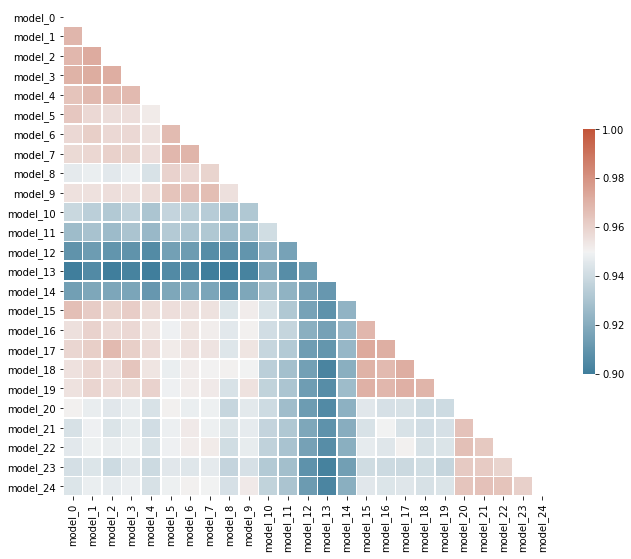

In [5]:
corr = oofs[pred_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.9, vmax=1.0, # center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [6]:
reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000))
reg.fit(oofs[pred_cols], oofs["target"])
print(f"Best score: {np.sqrt(-reg.best_score_):0.5f}")
reg.coef_

Best score: 0.45641


array([ 0.04273704,  0.0520481 ,  0.06045622,  0.02732763,  0.06043136,
        0.0562994 ,  0.05682022,  0.12040311,  0.05050899,  0.05793249,
        0.02055318,  0.03420677, -0.02867862, -0.02899512, -0.04169844,
        0.06960041, -0.0184979 ,  0.0181367 ,  0.06114595,  0.03705664,
        0.06860142,  0.0525309 ,  0.02647658,  0.07929181,  0.08550163])

In [7]:
scores = cross_val_score(
    LinearRegression(),
    oofs[pred_cols],
    oofs["target"],
    scoring="neg_mean_squared_error",
    cv=LeaveOneOut(),
    n_jobs=-1,
)
print(f"Best score: {np.sqrt(np.mean(-scores)):0.5f}")

Best score: 0.45752


# Model selection

In [8]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)  # allows duplicate elements
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

subsets = list(powerset(pred_cols))
len(subsets)

33554432

In [9]:
# best_score = 10
# best_cols = None

# for s in tqdm(subsets[1:]):
#     reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000))
#     reg.fit(oofs[list(s)], oofs["target"])
#     score = np.sqrt(-reg.best_score_)
    
#     if score < best_score:
#         best_score = score
#         best_cols = list(s)
        
# print(f"Best score: {best_score:0.5f}")
# print("Best cols", best_cols)

In [10]:
# ['model_1', 'model_2', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_11', 'model_13', 'model_16']